# Text-to-image

In [1]:
ckp = "runwayml/stable-diffusion-v1-5"
ckp_data = "0xJustin/Dungeons-and-Diffusion"

### 1. load data

In [2]:
# load dataset

from datasets import load_dataset

data = load_dataset(ckp_data, split="train")
data

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image', 'text'],
    num_rows: 2475
})

D&D Character, human a woman in armor


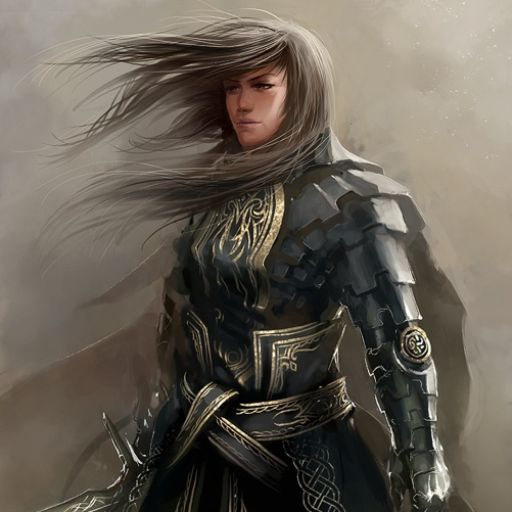

In [3]:
ind = 101
print(data[ind]["text"])
data[ind]["image"]

In [60]:
data[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'text': 'D&D Character, kenku a person with a hood on'}

### 2. load tokenizer

In [3]:
from transformers import CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained(ckp, subfolder="tokenizer", use_safetensors=True)
tokenizer

CLIPTokenizer(name_or_path='runwayml/stable-diffusion-v1-5', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

### 3. data process

In [4]:
# preprocess

# the input size of unet is 64, so our default input size of vae is 512

from torchvision import transforms

def preprocess(samples):

    transform = transforms.Compose([
        transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])


    images = [image.convert("RGB") for image in samples["image"]]
    samples["pixel_values"] = [transform(img) for img in images]
    toks = tokenizer(samples["text"], max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt")
    samples["input_ids"] = toks.input_ids
    
    return samples

In [5]:
# collate

import torch

def collate_fnt(samples):
    pixel_values = torch.stack([sample["pixel_values"] for sample in samples])
    input_ids = torch.stack([sample["input_ids"] for sample in samples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}


### 4. dataloader

In [6]:

train_set = data.with_transform(preprocess)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, collate_fn=collate_fnt, batch_size=8)

In [71]:
train_set[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'text': 'D&D Character, kenku a person with a hood on',
 'pixel_values': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'input_ids': tensor([49406,   323,   261,

In [72]:
next(iter(train_loader))

{'pixel_values': tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           ...,
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
 
          [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           ...,
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
           [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
 
          [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000

### 5. load scheduler

In [7]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_pretrained(ckp, subfolder="scheduler")
scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.29.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [9]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', False),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 1),
            ('rescale_betas_zero_snr', False),
            ('_use_default_values',
             ['sample_max_value',
              'rescale_betas_zero_snr',
              'prediction_type',
              'variance_type',
              'thresholding',
              'clip_sample_range',
              'dynamic_thresholding_ratio',
              'timestep_spacing']),
            ('_class_name', 'DDPMScheduler'),
            ('_diff

### 6. load unet

In [8]:
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(ckp, subfolder="unet")
unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [11]:
unet.config

FrozenDict([('sample_size', 64),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attenti

### 7. load text encoder

In [9]:
from transformers import CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(ckp, subfolder="text_encoder", use_safetensors=True)
text_encoder

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

### 8. load vae

In [10]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained(ckp, subfolder="vae", use_safetensors=True)
vae

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [29]:
vae.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 4),
            ('norm_num_groups', 32),
            ('sample_size', 512),
            ('scaling_factor', 0.18215),
            ('shift_factor', None),
            ('latents_mean', None),
            ('latents_std', None),
            ('force_upcast', True),
            ('use_quant_conv', True),
            ('use_post_quant_conv', True),
            ('_use_default_values',
             ['scaling_factor',
              'use_q

### 8. wrap to peft

In [11]:
from peft import LoraConfig

unet_lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)

In [12]:
from peft import get_peft_model

lora_unet = get_peft_model(unet, unet_lora_config)
lora_unet.print_trainable_parameters()

trainable params: 1,594,368 || all params: 861,115,332 || trainable%: 0.1852


### 7. define optimizer

In [13]:
optimizer = torch.optim.AdamW(lora_unet.parameters(), lr=2e-4)

### 8. wrap to accelerator

In [14]:
from accelerate import Accelerator

accelerator = Accelerator(gradient_accumulation_steps=8)

lora_unet, optimizer, train_loader = accelerator.prepare(lora_unet, optimizer, train_loader)

### 9. move vae and text encoder

In [15]:
text_encoder = text_encoder.to(accelerator.device)
vae = vae.to(accelerator.device)

### 10. generate

In [21]:
## evaluation

from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import numpy as np

def generate(_unet):

    prompt = "D&D Character, human a woman with a sword"

    pipe = StableDiffusionPipeline.from_pretrained(ckp, unet=accelerator.unwrap_model(_unet))
    image = pipe(prompt, batch_size=4, generator=torch.Generator().manual_seed(42)).images[0]

    plt.imshow(image)
    return image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

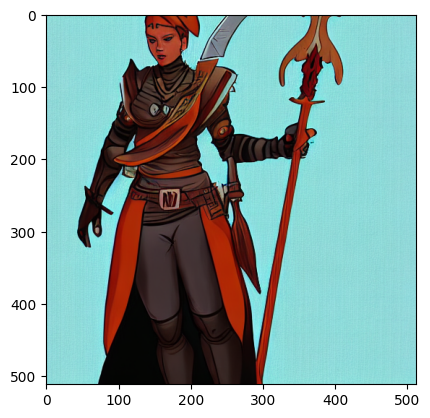

In [31]:
# generate before finetune

image = generate()

### 10. train loop

In [19]:
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm

def train(epochs=3, log_steps=100):

    global_step = 0

    for e in range(epochs):

        train_loss = 0.0

        for batch in tqdm(train_loader):

            with accelerator.accumulate(unet):

                optimizer.zero_grad()

                # encode image to latent space
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                latents *= vae.config.scaling_factor

                # sample noise
                noise = torch.randn_like(latents)

                # sample timestep
                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.shape[0], ), device=latents.device)
                timesteps = timesteps.long()

                # add noise
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)

                # encode text
                encoded_text = text_encoder(batch["input_ids"])[0]

                # predict noise
                noise_pred = lora_unet(noisy_latents, timesteps, encoded_text).sample

                # loss 
                loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

                # back propagation
                accelerator.backward(loss)

                # clip weights
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), 1.0)

                optimizer.step()

                if accelerator.sync_gradients:

                    # increment counter
                    global_step += 1

                    if global_step % log_steps == 0:

                        # update log
                        loss = accelerator.reduce(loss, "mean")

                        # print
                        accelerator.print(f"epoch {e}: step: {global_step}, loss: {loss.item()}")


    accelerator.end_training()

In [20]:
train(epochs=1, log_steps=100)

/tmp/ipykernel_822869/1250972819.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_loader):


  0%|          | 0/310 [00:00<?, ?it/s]

In [21]:
from accelerate import notebook_launcher

notebook_launcher(train, (1, 100), num_processes=1)

Launching training on CPU.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


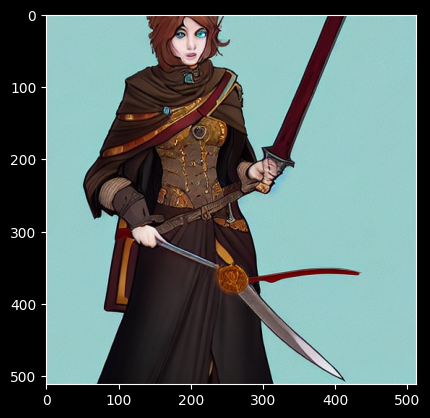

In [22]:
image = generate(lora_unet)

In [12]:
!nvidia-smi

Mon Aug 19 11:57:11 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:08:00.0 Off |                  N/A |
| 70%   69C    P2            324W /  420W |   24043MiB /  24576MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----